In [59]:
# Used to pull data from Reddit
import praw
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import statsmodels.formula.api
import matplotlib.pyplot as plt
import time
import re


from gensim.models import Word2Vec
from nltk.corpus import brown
import nltk
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from pdpbox import pdp, get_dataset, info_plots

import tensorflow_hub as hub
import multiprocessing
from google.cloud import bigquery

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import inspection

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

from sklearn import model_selection
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import pipeline

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')

In [90]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
        return text

def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "urltoken")
    #text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text


In [ ]:
post_df.shape

# Data Import

In [3]:
# Read in cleaned up data
post_df = pd.read_json('complete_elmo.json', orient='split', dtype={'elmo_embedding':'float32'})
post_df['elmo_embedding'] = post_df['elmo_embedding'].apply(lambda x: np.array(x, dtype='float32'))

# Models

### Random Forest with TF-IDF

In [4]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['title_clean'],
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

# Define classifier, over sampler, under sampler and feature selector
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = RandomForestClassifier(n_jobs=10, n_estimators=200)
osmpl = over_sampling.SMOTE(n_jobs=10)
usmpl = under_sampling.TomekLinks(n_jobs=10)

# Create pipeline
tfidf_pipe = pipeline.Pipeline([('vectorizer', vectorizer), 
                                ('over_sampler', osmpl),
                                ('under_sampler', usmpl),
                                ('classifier', tfidf_model)])

# Fit pipeline
start_time = time.time()
tfidf_pipe.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

# Put results on X_test on DataFrame
test_df = pd.DataFrame({'tfidf_pred': tfidf_pipe.predict(X_test), 'tfidf_true': y_test})

Model training took: 71.73 seconds


In [5]:
post_df['rf_tfidf_pred'] = tfidf_pipe.predict(post_df['title_clean'])

### Neural Net with TFIDF

In [260]:
X_train, X_test, y_train, y_test = train_test_split(post_df['title_clean'],
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [261]:
def ELMoEmbedding(x):
    embed = hub.Module("elmo_model")
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

# Build NeuralNet model
def build_model(): 
    input_embedding = Input(shape=(X_train_transformed.shape[1],), dtype='float64')
    drop = keras.layers.Dropout(rate=0.3)(input_embedding)
    dense = Dense(256, activation='relu')(drop)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_embedding], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_tfidf = build_model()
nn_tfidf.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 16498)]           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16498)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4223744   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 4,224,001
Trainable params: 4,224,001
Non-trainable params: 0
_________________________________________________________________


In [262]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    nn_tfidf.fit(X_train_transformed, 
                 y_train, 
                 epochs=10, 
                 batch_size=256,
                 validation_split=0.2)

Train on 17406 samples, validate on 4352 samples
Epoch 1/10
17406/17406 [==============================] - 13s 733us/sample - loss: 0.6266 - acc: 0.6640 - val_loss: 0.5827 - val_acc: 0.6781
Epoch 2/10
17406/17406 [==============================] - 13s 725us/sample - loss: 0.5234 - acc: 0.7377 - val_loss: 0.5292 - val_acc: 0.7323
Epoch 3/10
17406/17406 [==============================] - 13s 719us/sample - loss: 0.4480 - acc: 0.7902 - val_loss: 0.5325 - val_acc: 0.7328
Epoch 4/10
17406/17406 [==============================] - 13s 721us/sample - loss: 0.4022 - acc: 0.8176 - val_loss: 0.5451 - val_acc: 0.7277
Epoch 5/10
17406/17406 [==============================] - 12s 686us/sample - loss: 0.3677 - acc: 0.8347 - val_loss: 0.5590 - val_acc: 0.7210
Epoch 6/10
17406/17406 [==============================] - 12s 705us/sample - loss: 0.3462 - acc: 0.8457 - val_loss: 0.5755 - val_acc: 0.7174
Epoch 7/10
17406/17406 [==============================] - 12s 712us/sample - loss: 0.3269 - acc: 0.8525 -

In [284]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = nn_tfidf.predict(X_test_transformed, use_multiprocessing=True, workers=4)
    
test_df['nn_tfidf_pred'] = y_pred
test_df['nn_tfidf_true'] = y_test.reset_index(drop=True)

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7ffa363bad90>
Traceback (most recent call last):
  File "/home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [267]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = nn_tfidf.predict(vectorizer.transform(post_df['title_clean']),
                              use_multiprocessing=True,
                              workers=4)
    
post_df['nn_tfidf_pred'] = y_pred

### Random Forest with ELMo Embedding

In [268]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['elmo_embedding'].tolist(),
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

# Define classifier, over sampler, under sampler and feature selector
elmo_model = RandomForestClassifier(n_jobs=10, n_estimators=100)
osmpl = over_sampling.SMOTE(n_jobs=10)
usmpl = under_sampling.TomekLinks(n_jobs=10)

# Create pipeline
elmo_pipe = pipeline.Pipeline([('over_sampler', osmpl),
                               ('under_sampler', usmpl),
                               ('classifier', elmo_model)])

# Fit pipeline
start_time = time.time()
elmo_pipe.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

# Put results on X_test on DataFrame
test_df.reset_index(inplace=True, drop=True)
test_df['elmo_pred'] = elmo_pipe.predict(X_test)
test_df['elmo_true'] = y_test.reset_index(drop=True)

Model training took: 275.81 seconds


In [270]:
post_df['rf_elmo_pred'] = elmo_pipe.predict(post_df['elmo_embedding'].tolist())

### Neural Net with ELMo Embedding

In [271]:
def ELMoEmbedding(x):
    embed = hub.Module("elmo_model")
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(np.array(post_df['elmo_embedding'].tolist()),
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

# Build NeuralNet model
def build_model(): 
    input_embedding = Input(shape=(1024,), dtype='float64')
    drop = keras.layers.Dropout(rate=0.3)(input_embedding)
    dense = Dense(256, activation='relu')(drop)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_embedding], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_elmo = build_model()
nn_elmo.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


In [272]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    nn_elmo.fit(X_train, 
                y_train, 
                epochs=10, 
                batch_size=256,
                validation_split=0.2)

Train on 17406 samples, validate on 4352 samples
Epoch 1/10
17406/17406 [==============================] - 1s 75us/sample - loss: 0.6244 - acc: 0.6807 - val_loss: 0.5868 - val_acc: 0.6916
Epoch 2/10
17406/17406 [==============================] - 1s 58us/sample - loss: 0.5795 - acc: 0.7033 - val_loss: 0.5632 - val_acc: 0.7040
Epoch 3/10
17406/17406 [==============================] - 1s 57us/sample - loss: 0.5622 - acc: 0.7156 - val_loss: 0.5585 - val_acc: 0.7086
Epoch 4/10
17406/17406 [==============================] - 1s 54us/sample - loss: 0.5571 - acc: 0.7196 - val_loss: 0.5661 - val_acc: 0.7038
Epoch 5/10
17406/17406 [==============================] - 1s 50us/sample - loss: 0.5480 - acc: 0.7253 - val_loss: 0.5481 - val_acc: 0.7206
Epoch 6/10
17406/17406 [==============================] - 1s 53us/sample - loss: 0.5451 - acc: 0.7235 - val_loss: 0.5552 - val_acc: 0.7139
Epoch 7/10
17406/17406 [==============================] - 1s 51us/sample - loss: 0.5400 - acc: 0.7312 - val_loss: 0.5

In [273]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = nn_elmo.predict(X_test, use_multiprocessing=True, workers=4)
    
test_df['nn_elmo_pred'] = y_pred
test_df['nn_elmo_true'] = y_test.reset_index(drop=True)

In [278]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = nn_elmo.predict(np.array(post_df['elmo_embedding'].tolist()),
                             use_multiprocessing=True,
                             workers=4)
    
post_df['nn_elmo_pred'] = y_pred

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7ffa363bad90>
Traceback (most recent call last):
  File "/home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [ ]:
    h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)
    conv_layers_for_all_kernel_sizes = []
    num_filters = [2, 2, 2]
    kernel_sizes = [2, 3, 4]
    for filters, kernel_size in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(input_embedding)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    input_embedding = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

# Model Evaluation

In [286]:
test_df['nn_elmo_pred'] = test_df['nn_elmo_pred'].apply(lambda x: 0 if x < 0.5 else 1)
test_df['nn_tfidf_pred'] = test_df['nn_tfidf_pred'].apply(lambda x: 0 if x < 0.5 else 1)

test_df = test_df[['tfidf_pred',
                   'tfidf_true', 
                   'nn_tfidf_pred', 
                   'nn_tfidf_true',
                   'elmo_pred',
                   'elmo_true',
                   'nn_elmo_pred',
                   'nn_elmo_true']]

In [287]:
titles = ['Random Forest with TF-IDF ', 
          'Neural Net with TF-IDF',
          'Random Forest with ELMo Embedding',
          'Neural Net with ELMo Embedding']

for c, t in zip(np.arange(0, 8, 2), titles):
    print(t)
    print(metrics.classification_report(test_df[test_df.columns[c+1]], test_df[test_df.columns[c]]))

Random Forest with TF-IDF 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      3551
           1       0.63      0.65      0.64      1889

    accuracy                           0.75      5440
   macro avg       0.72      0.72      0.72      5440
weighted avg       0.75      0.75      0.75      5440

Neural Net with TF-IDF
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      3613
           1       0.33      0.34      0.33      1827

    accuracy                           0.54      5440
   macro avg       0.49      0.49      0.49      5440
weighted avg       0.55      0.54      0.54      5440

Random Forest with ELMo Embedding
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      3578
           1       0.66      0.42      0.51      1862

    accuracy                           0.73      5440
   macro avg       0.70      0.65      0.66 

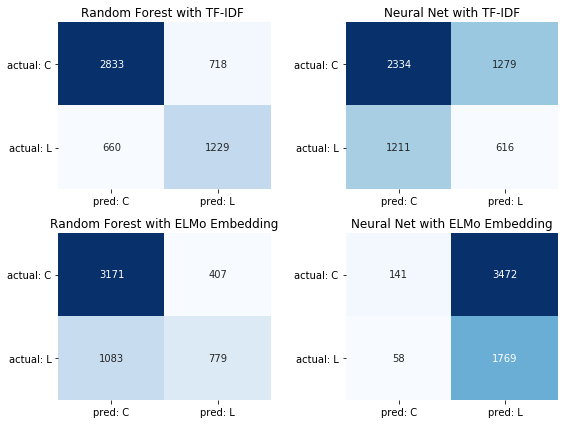

In [288]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
for a, b, c in zip(np.arange(0, 8, 2), [(0,0), (0,1), (1,0), (1,1)], titles):
    sns.heatmap(metrics.confusion_matrix(test_df[test_df.columns[a+1]], test_df[test_df.columns[a]]),
                xticklabels=['pred: C', 'pred: L'],
                yticklabels=['actual: C', 'actual: L'],
                annot=True,
                fmt='g',
                cmap='Blues', 
                cbar=False,
                ax=ax[b[0], b[1]])
    ax[b[0], b[1]].set_title(c)
    ax[b[0], b[1]].tick_params(axis='y', rotation=0)
    
plt.tight_layout()
plt.show()

# Analysis

### PDP and ICE Plots

In [4]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['title_clean'],
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

# Define classifier, over sampler, under sampler and feature selector
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = RandomForestClassifier(n_jobs=10, n_estimators=200)
osmpl = over_sampling.SMOTE(n_jobs=10)
usmpl = under_sampling.TomekLinks(n_jobs=10)

# Create pipeline
tfidf_pipe = pipeline.Pipeline([('vectorizer', vectorizer), 
                                ('over_sampler', osmpl),
                                ('under_sampler', usmpl),
                                ('classifier', tfidf_model)])

# Fit pipeline
start_time = time.time()
tfidf_pipe.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

Model training took: 61.97 seconds


In [11]:
feat_df = pd.DataFrame({'feature':vectorizer.get_feature_names(), 'importance':tfidf_model.feature_importances_})
feat_df = feat_df.sort_values(by='importance', ascending=False)

tf-idf weight  gives us a measure on how important a word is to a document in a corpus. The higher the tf-idf score is the more important the 

In [60]:
wc_vectorizer = CountVectorizer(stop_words='english')

In [81]:
count_df = wc_vectorizer.fit_transform(X_train)

In [85]:
sum_words = count_df.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in wc_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [88]:
pd.DataFrame(words_freq, columns=['word', 'x`frequency'])

,word,frequency
0,trump,3104
1,conservative,1273
2,just,818
3,people,808
4,like,749
5,conservatives,707
6,democrats,695
7,think,655
8,vote,631
9,does,585


In [68]:
count_df = pd.DataFrame(count_df.toarray(), columns=wc_vectorizer.get_feature_names())

In [62]:
count_df.to

<27198x18300 sparse matrix of type '<class 'numpy.int64'>'
	with 173120 stored elements in Compressed Sparse Row format>

In [ ]:
feat_df = pd.DataFrame({'feature':vectorizer.get_feature_names(), 'importance':tfidf_model.feature_importances_})
feat_df = feat_df.sort_values(by='importance', ascending=False)

feature_names = vectorizer.get_feature_names()
X_train_transformed = vectorizer.transform(X_train)
X_train_transformed = X_train_transformed.toarray()
feature_df = pd.DataFrame(X_train_transformed, columns=feature_names)

In [30]:
def plot_ice(feat, df):
    pdp_feat = pdp.pdp_isolate(model=tfidf_model,
                               dataset=df,
                               model_features=df.columns, 
                               feature=feat)
    
    fig, axes = pdp.pdp_plot(pdp_feat,
                             feat, 
                             frac_to_plot=0.1, 
                             plot_lines=True,
                             plot_pts_dist=True,
                             figsize=(10,8))
    axes['pdp_ax']['_pdp_ax'].set_ylim(-1, 1)


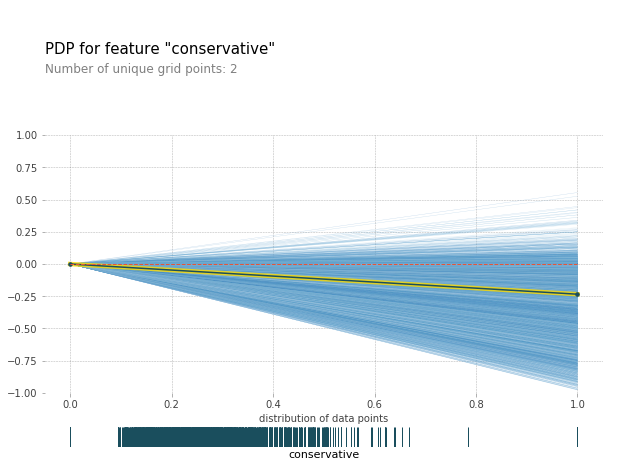

In [31]:
plot_ice('conservative')

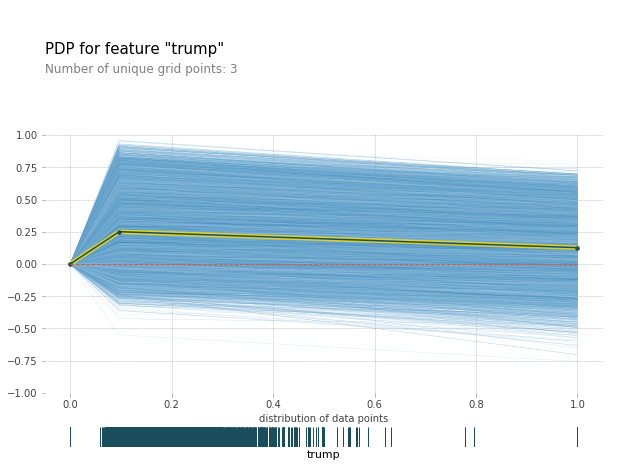

In [34]:
plot_ice('trump')

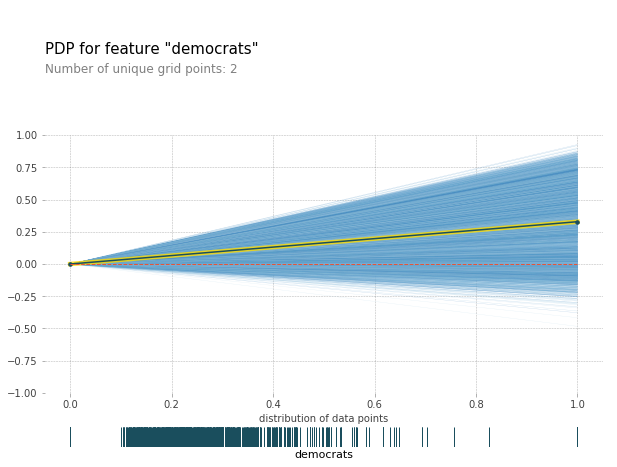

In [35]:
plot_ice('democrats')

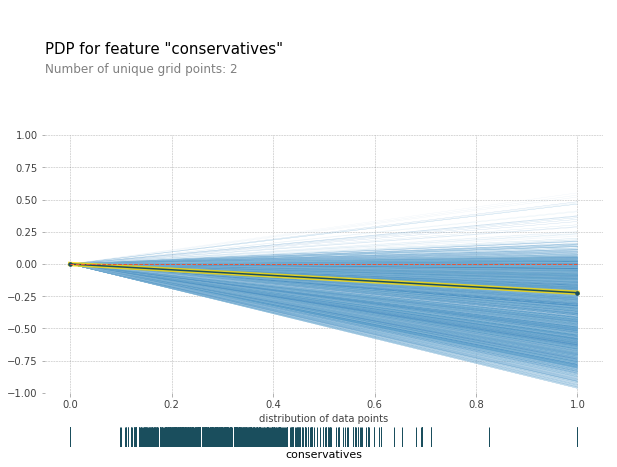

In [36]:
plot_ice('conservatives')

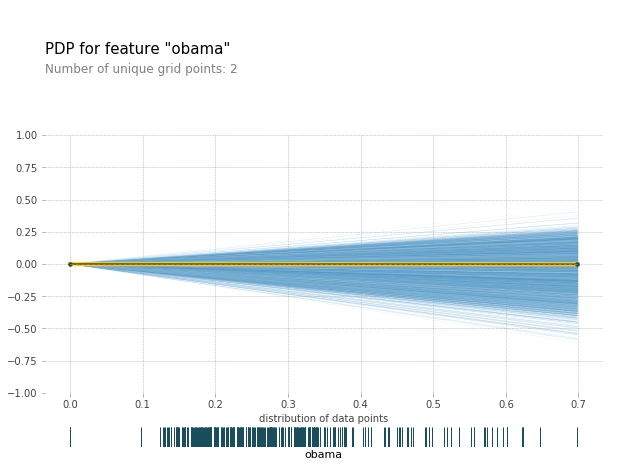

In [58]:
plot_ice('obama')

In [56]:
post_df[post_df['title_clean'].str.contains('liberal')][['title_clean', 'political_leaning']].loc[18]['title_clean']

'something liberals never talk about or refuse to admit universal healthcare cannot work in a degenerate society'

In [ ]:
post_df[post_df['title_clean'].str.contains('liberal')][['title_clean', 'political_leaning']].loc[18]['title_clean']

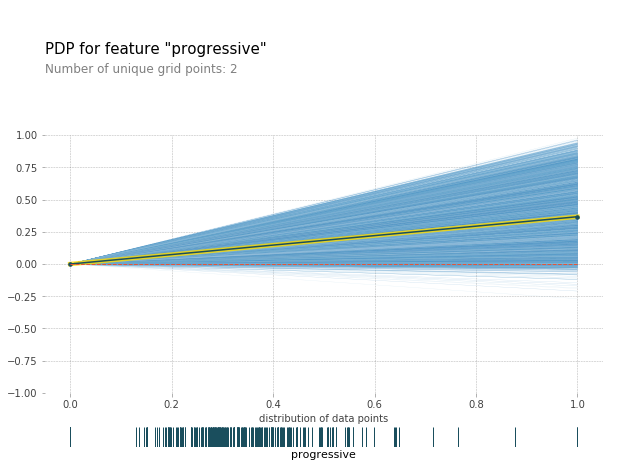

In [37]:
plot_ice('progressive')

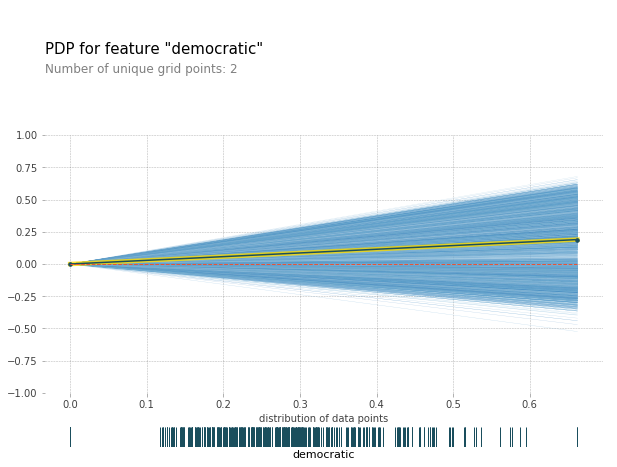

In [38]:
plot_ice('democratic')

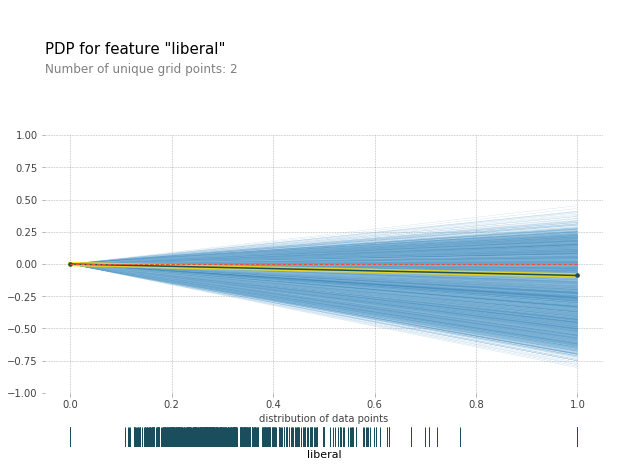

In [39]:
plot_ice('liberal')

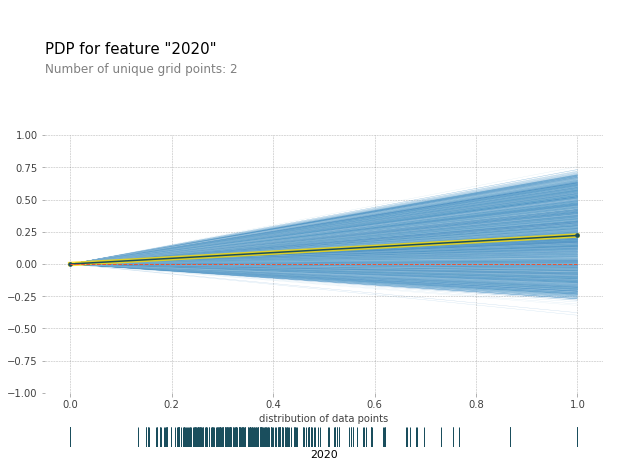

In [40]:
plot_ice('2020')

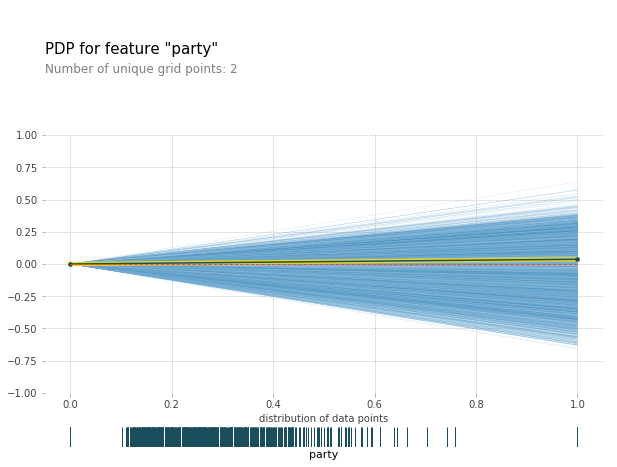

In [41]:
plot_ice('party')

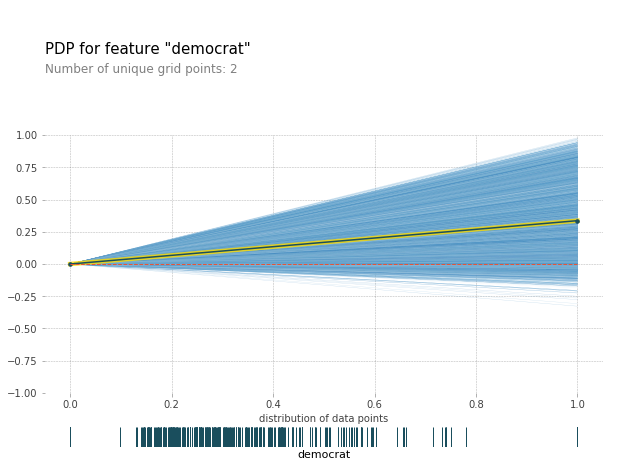

In [42]:
plot_ice('democrat')

In [33]:
feat_df.head(10)

,feature,importance
3445,conservative,0.022569
15210,trump,0.019184
4269,democrats,0.014860
3458,conservatives,0.011327
11417,progressive,0.008747
4264,democratic,0.008092
8613,liberal,0.007535
221,2020,0.005873
10604,party,0.005558
4262,democrat,0.004976


# Misc

In [149]:
from sklearn import cluster

In [167]:
cluster_model = cluster.k_means(post_df['elmo_embedding'].tolist(), 8)

In [168]:
post_df['cluster'] = cluster_model[1]

In [169]:
post_df['cluster'].value_counts()

0    8611
7    8051
4    5071
2    2886
3    1356
1     766
5     288
6     169
Name: cluster, dtype: int64

# To Be Sorted

In [ ]:
# Define classifier, over sampler, under sampler and feature selector
model = RandomForestClassifier(n_jobs=10)
osmpl = over_sampling.SMOTE(kind='regular', n_jobs=10)
usmpl = under_sampling.EditedNearestNeighbours(n_neighbors=5, n_jobs=10)

# Create pipeline
pipe = pipeline.Pipeline([('over_sampler', osmpl), ('under_sampler', usmpl), ('classifier', model)])

gs_parameter = dict(classifier__n_estimators=np.arange(300, 600, 100), 
                    classifier__max_depth=np.arange(100,400, 100))

grid_search = model_selection.GridSearchCV(pipe,
                                           param_grid=gs_parameter,
                                           scoring='f1_macro',
                                           cv=5)

grid_search.fit(X_train, y_train)

In [182]:
start_time = time.time()
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=10,
                               class_weight='balanced')
model.fit(X_train, y_train)
print('%s seconds' % (time.time() - start_time))

13.681684732437134 seconds


In [183]:
print('Dummy Model')
print(metrics.classification_report(y_test, np.zeros(y_test.shape[0])))
print('With Over/Under Sampling')
print(metrics.classification_report(y_test, pipe.predict(X_test)))
print('Regular RandomForest')
print(metrics.classification_report(y_test, model.predict(X_test)))

Dummy Model
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3585
           1       0.00      0.00      0.00      1855

    accuracy                           0.66      5440
   macro avg       0.33      0.50      0.40      5440
weighted avg       0.43      0.66      0.52      5440

With Over/Under Sampling
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      3585
           1       0.66      0.43      0.52      1855

    accuracy                           0.73      5440
   macro avg       0.71      0.66      0.67      5440
weighted avg       0.72      0.73      0.71      5440

Regular RandomForest
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      3585
           1       0.79      0.25      0.38      1855

    accuracy                           0.72      5440
   macro avg       0.75      0.61      0.60      5440
weighted avg    

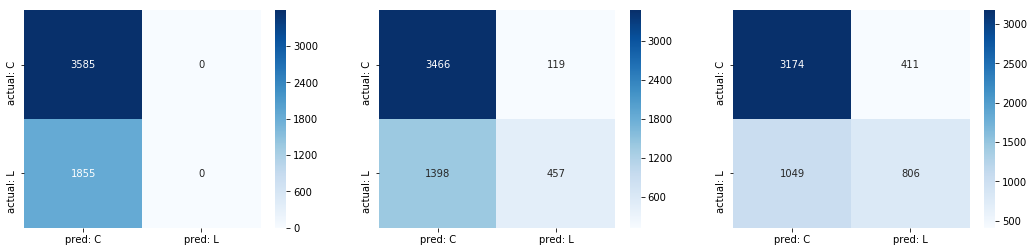

In [185]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(metrics.confusion_matrix(y_test, np.zeros(y_test.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(y_test, model.predict(X_test)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

sns.heatmap(metrics.confusion_matrix(y_test, pipe.predict(X_test)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[2])

plt.show()

In [186]:
post_df.head()

,title_clean,elmo_embedding,political_leaning
0,what was the moment or event that made you rea...,"[-0.078861244, -0.113778666, 0.0038933286, -0....",0
1,congratulations we have a guess when we hit 20...,"[-0.34211433, -0.33793145, -0.08896699, -0.123...",0
2,what are your opinions on the prohibition of m...,"[-0.04286085, -0.03858882, -0.025878163, -0.07...",0
3,they keep citing violence against transgender ...,"[-0.07348777, 0.20026228, -0.059132166, -0.123...",0
4,why is rpolitics so biased and attack you for ...,"[-0.11819296, -0.24966277, 0.17514223, -0.2276...",0


 # Misc

In [52]:
sample_df = title_df.sample(n=40)[['title', 'political_leaning']]
sample_df['title_clean'] = sample_df['title'].apply(cleanText)
sample_df['word_token'] = sample_df['title_clean'].apply(nltk.word_tokenize)
sample_df['word_count'] = sample_df['word_token'].apply(lambda x: len(x))
sample_df = sample_df[sample_df['word_count']!=0].reset_index(drop=True)

X = np.array(sample_df['title_clean'])
y = np.array(sample_df['political_leaning'])


In [53]:
batch_size = 40
X_list = [X[i:i+batch_size] for i in range(0, X.shape[0], batch_size)]

X_vecs = []
elmo_model = hub.Module('elmo_model', trainable=False)
for x in enumerate(X_list):
    embeddings = elmo_model(x[1], signature="default", as_dict=True)['default']
    start_time = time.time()
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        elmo_embedding = sess.run(embeddings)
    print('batch', x[0], 'complete - ', '%s seconds' % (time.time() - start_time))
    X_vecs += list(elmo_embedding)

batch 0 complete -  37.912352323532104 seconds


In [108]:
test = np.array(X_vecs)

In [114]:
len(test.reshape(1024, 40))

1024